**This notebook explores churn prediction for a trading platform, based on user equity and features, using Logistic Regression, LightGBM and XGBoost models**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/My Drive/Machine Learning/equity_value_data.csv"

In [ ]:
# Importing all necessary packages
import pandas as pd
import numpy as np
import datetime
pd.options.display.max_rows = 400
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_score,recall_score,f1_score,accuracy_score
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import feature_selection
import warnings
warnings.filterwarnings("ignore")
np.random.seed(2021)

In [ ]:
raw_df = pd.read_csv(dataset_path,parse_dates=['timestamp']) #timestamp column must be processed as a datetime field

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   timestamp     1119158 non-null  datetime64[ns, UTC]
 1   close_equity  1119158 non-null  float64            
 2   user_id       1119158 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 25.6+ MB


In [ ]:
raw_df.head()

,timestamp,close_equity,user_id
0,2016-11-16 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [ ]:
raw_df.sample(5)

,timestamp,close_equity,user_id
373806,2017-06-26 00:00:00+00:00,1262.58,518b69e1bf41dbb0f0dfdac63ad73d65
405046,2017-04-24 00:00:00+00:00,1332.19,f6e8c723f89b5455cfda044677332cf7
117802,2017-06-08 00:00:00+00:00,13682.13,ee88d48e73afd43e390a59dfbb7b7c87
19325,2017-07-14 00:00:00+00:00,25969.73,b04fb468f3d17ada4b46b6520fd0c24f
621096,2017-07-18 00:00:00+00:00,57.80,9c1fc49ea91b662b200f292a70d125c3


In [ ]:
raw_df.shape

(1119158, 3)

In [ ]:
raw_df['closing_date'] = raw_df["timestamp"].dt.date #creating a new column with just date from timestamp

In [ ]:
raw_df.head() #shows new column

,timestamp,close_equity,user_id,closing_date
0,2016-11-16 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16
1,2016-11-17 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-17
2,2016-11-18 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-18
3,2016-11-21 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-21
4,2016-11-22 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-22


What is data range of obesevation data? And how many users are present in analysis?


In [ ]:
min(raw_df['closing_date']),max(raw_df['closing_date']) #shows date range for data

(datetime.date(2016, 8, 16), datetime.date(2017, 8, 18))

Observation data for this analysis is between 2016-08-16 and 2017-08-18

In [ ]:
raw_df['user_id'].nunique() #5584 unique users

5584

Let's understand when is the first time user has more than $10 Equity

In [ ]:
#identifies the first recorded date for each user in the dataset
user_first_appearence_date = raw_df.groupby('user_id').agg({'closing_date': 'min'}).reset_index()
#groups the raw_df DataFrame by user_id and finds the minimum closing_date for each user. reset_index() method is used to convert the grouped output back into a DataFrame.
user_first_appearence_date.columns = ['user_id', 'first_active_date']
#renaming closing_date to apt first_active_date

In [ ]:
user_first_appearence_date.sample(2)

,user_id,first_active_date
5486,fbad1dcd9481a625ca1848002031f830,2016-09-30
3596,a5e9a5afae4b18aaa3fe98052c76e1ca,2016-08-22


In [ ]:
user_first_appearence_date['year_month'] = pd.to_datetime(user_first_appearence_date['first_active_date']).dt.strftime("%Y-%m") #get first yyyy-mm

In [ ]:
user_first_appearence_date.sample(2)

,user_id,first_active_date,year_month
555,19b6e37c9d358c981c78f59ad4221b08,2016-08-18,2016-08
4306,c6fe662ac469e4f793ce4bbb84524e14,2016-08-22,2016-08


In [ ]:
user_first_appearence_date['year_month'].value_counts()

,count
year_month,
2016-08,3335
2017-02,535
2017-01,452
2016-11,307
2016-12,276
2016-09,252
2016-10,242
2017-03,162
2017-07,7


***All users whose first appearance in the dataset was in August 2016 also had their first recorded instance of having >= $10 in equity within that same month***

# Assumptions
If a user had low equity for 28 days for any rolling 28 day window in observation period (i.e. between
2016-08-16 to 2017-08-18) then user is considered to be churned

Even if a user has first appeared date (i.e. first date in the in "equity_value_data" dataset with equity>= $10) in 2017, it means user was active before 2016-08-16 (as he is included in feature data), and
dates prior to his/her first appeared date are considered to low equity days

# Creating Base Data

In [ ]:
user_base = pd.DataFrame({'user_id':raw_df['user_id'].unique()})
user_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5584 non-null   object
dtypes: object(1)
memory usage: 43.8+ KB


In [ ]:
#creating entry for every day
dates_base = pd.DataFrame({'closing_date':[min(raw_df['closing_date'])+datetime.timedelta(days=i) for i in range(368)]})
dates_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   closing_date  368 non-null    object
dtypes: object(1)
memory usage: 3.0+ KB


In [ ]:
base_df = user_base.merge(dates_base,how='cross')
print(5584*368)
base_df.shape

2054912


(2054912, 2)

In [ ]:
base_df_with_equity = base_df.merge(raw_df[['closing_date', 'user_id', 'close_equity']], how='left', on=['closing_date', 'user_id'])

In [ ]:
base_df_with_equity.sample(5)

,user_id,closing_date,close_equity
1217990,3d7c4d0d4a9c786273ec9c2177d6b852,2017-05-21,NaN
1016380,6f216717f494df0d013acecf1a9cc9b0,2017-07-14,1321.77
353279,321579e9b0e9293f99f20e5c3f50c5be,2017-08-18,NaN
1947194,894155930b1a3d2b70d1a2d96c16874d,2016-11-30,NaN
1625906,ad628b985ecf34d53ed54fe5bbc40c67,2016-11-06,NaN


In [ ]:
base_df_with_equity['low_equity'] = np.where(base_df_with_equity['close_equity'] >= 10,0,1)
#low_equity = 0 implies < $10

In [ ]:
base_df_with_equity.sample(5)

,user_id,closing_date,close_equity,low_equity
1051269,9e4fbf55c7fada9d4412e7e3ef384a1a,2017-05-04,2761.10,0
1881558,1bfd0e582580f1c9fcd387002c576cb6,2017-07-24,10530.34,0
915087,a2c1ca082061ef5079a2fb447daac8d0,2017-04-12,NaN,1
384516,474ae7e5ffeb6eef5a98347eeef61407,2017-07-06,86.96,0
1812512,6fb22abee567ac55add87365f30c7983,2016-12-06,NaN,1


**Rolling sum of low equity flag data grouped by user when dates are sorted**

In [ ]:
base_df_with_equity['rolling_low_equity'] = base_df_with_equity.groupby('user_id')['low_equity'].rolling(28).sum().reset_index(0,drop=True)

**Creating churn flag when rollling 28 day sum of low equity flag is equal to 28**

In [ ]:
base_df_with_equity['churn'] = np.where(base_df_with_equity['rolling_low_equity'] == 28, 1, 0)

In [ ]:
base_df_with_equity.sample(5)

,user_id,closing_date,close_equity,low_equity,rolling_low_equity,churn
109971,07496cad810a612bd388a5ebac379dc5,2017-06-19,151.0940,0,9.0,0
1858702,404a4adaed771f89e26f9ac765b9f21b,2017-06-14,3213.3300,0,9.0,0
851983,3a2e06992a8db8b21d89c4532aa15460,2016-10-18,4130.7050,0,8.0,0
741443,c21bfe4fd5ca81322be77d7187183df9,2017-06-03,NaN,1,9.0,0
1624995,7b52e9b57b6da6102972f9403313c62b,2017-05-18,688.7035,0,8.0,0


**Let's get user level flag by aggregating churn flag to user level using max**

In [ ]:
user_churn_data = base_df_with_equity.groupby('user_id').agg({'churn':'max'}).reset_index()

In [ ]:
user_churn_data.sample(5)

,user_id,churn
1448,42eac027cb6877db98520037d412184e,1
2630,79e680494bf3cc5a53f78ef8e729855a,0
1630,4ad197726ba0a3fef96b0625690fbb5d,0
4714,d83c7bad31551b12322025f106bd5352,0
5316,f33e08e7ecef2a2c03a92cc2fb76d109,0


In [ ]:
user_churn_data['churn'].value_counts(normalize = True)

,proportion
churn,
0,0.545666
1,0.454334


**Add label to feature data**

In [ ]:
dataset2_path = "/content/drive/My Drive/Machine Learning/features_data.csv"
feature_df = pd.read_csv(dataset2_path)

In [ ]:
feature_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [ ]:
merged_df = feature_df.merge(user_churn_data,on='user_id',how='left')

In [ ]:
merged_df.sample(2)

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
2663,high_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,9.251267,stock,100.0,short_time_horizon,db96ffc56d2d9c753dc8e6371286426a,1
4513,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,4.259183,stock,200.0,short_time_horizon,2adc9ac635f25f99010c9f959471d4e5,1


In [ ]:
sum(merged_df['churn'].isnull())

0

**Final model dataset**

In [ ]:
merged_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,1
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,1
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0


**Let's Clip outliers with Q1-1.5 X IQR and Q3+1.5 X IQR logic**

In [ ]:
def treat_outliers(df,cols):
  for i in cols:
    q1 = np.percentile(df[i].values,25)
    q3 = np.percentile(df[i].values,75)
    iqr = q3-q1
    limits = [q1-1.5*iqr,q3+1.5*iqr]
    df[i] = df[i].clip(lower = limits[0], upper=limits[1])
  return df

In [ ]:
# Treat outliers
model_df = treat_outliers(merged_df,['time_spent','first_deposit_amount'])

In [ ]:
model_df.sample(2)

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
1422,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,20.568467,stock,25.0,med_time_horizon,633bd62e64a2f3dbeb0ff10ed0b8beb9,0
3939,high_risk_tolerance,good_investment_exp,very_important_liq_need,both,16.955083,stock,1175.0,short_time_horizon,3700e2bed0813653663903af26bdc016,0


**Create Train Test Split for model**

In [ ]:
train_df, test_df = train_test_split(model_df, test_size= 0.2, random_state = 2021)
# random_state allows control on randomness to get the same random split every time cell is executed

**Summary statistics of Train data**

In [ ]:
train_df.describe() #generates descriptive statistics of a DataFrame
#provides a summary of the central tendency, dispersion, and shape of the distribution of the numerical columns

,time_spent,first_deposit_amount,churn
count,4467.000000,4467.000000,4467.000000
mean,22.423515,327.035171,0.454444
std,24.626254,396.863671,0.497976
min,0.000000,0.000000,0.000000
25%,2.898725,50.000000,0.000000
50%,13.511483,100.000000,0.000000
75%,33.481850,500.000000,1.000000
max,80.286210,1175.000000,1.000000


In [ ]:
train_df[['risk_tolerance','investment_experience','liquidity_needs','platform','instrument_type_first_traded','time_horizon']].describe()
#outer []: to select one or more columns from a pandas DataFrame.
#innter []: createing a list of col names we want to select
#if only single col is required, one [] is enough. we are passing a list of cols to the df col selection operator []. a new df is created on which describe() can be called

,risk_tolerance,investment_experience,liquidity_needs,platform,instrument_type_first_traded,time_horizon
count,4467,4467,4467,4467,4467,4467
unique,3,4,3,3,11,3
top,high_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,stock,short_time_horizon
freq,2860,2038,3368,2856,3872,2280


#### **Defining continuous and categorical features for necessary treatment and also selecting features available as "Cols_for_model"**

**Categorical**: This list contains the names of the categorical features. These are features whose values represent categories or labels rather than numerical quantities. These need to be processed/encoded differently than numerical ones.

**Continuous**: Contains the names of the continuous/numerical features. Features whose values are numerical and can take on any value within a range. Requires preprocessing steps like scaling or normalization.


In [ ]:
cols_for_model = ['risk_tolerance','investment_experience','liquidity_needs', 'platform','time_spent','first_deposit_amount','time_horizon']

cat_features = ['risk_tolerance','investment_experience','liquidity_needs','platform','instrument_type_first_traded', 'time_horizon']

cont_features = ['time_spent','first_deposit_amount']

**Let's Visualize data to understand features better**

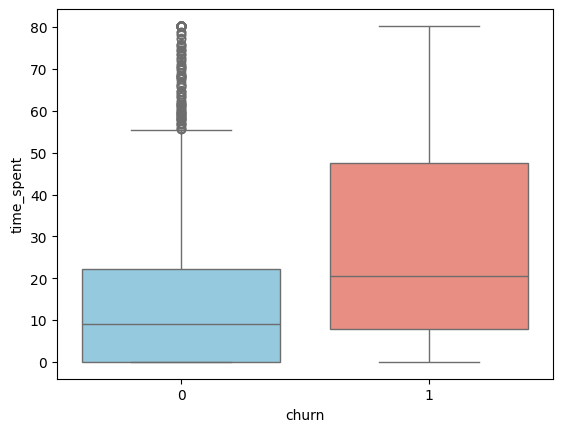

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette for the churn categories
churn_palette = {'0': 'skyblue', '1': 'salmon'} # Corrected keys to strings

ax = sns.boxplot(x="churn", y="time_spent", data= train_df, palette=churn_palette)
plt.show()

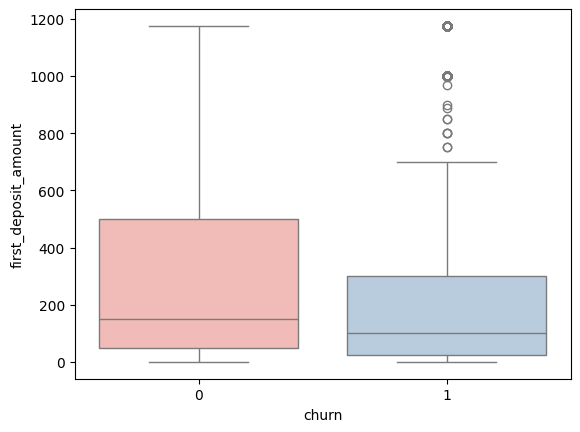

In [ ]:
ax = sns.boxplot(x="churn", y="first_deposit_amount", data = train_df, palette= "Pastel1")
plt.show()

**Mean of time spent for churned users is more that retained users. And for churned users first investment amount is tends be lower when compared to retained users.**

                        churn  user_id
risk_tolerance                        
high_risk_tolerance  0.409091     2860
low_risk_tolerance   0.492386      197
med_risk_tolerance   0.541135     1410


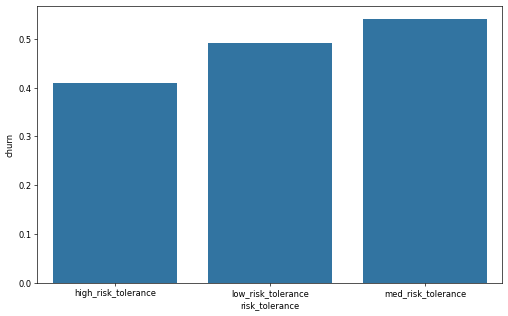

                             churn  user_id
investment_experience                      
extensive_investment_exp  0.415385       65
good_investment_exp       0.391351      925
limited_investment_exp    0.439647     2038
no_investment_exp         0.517721     1439


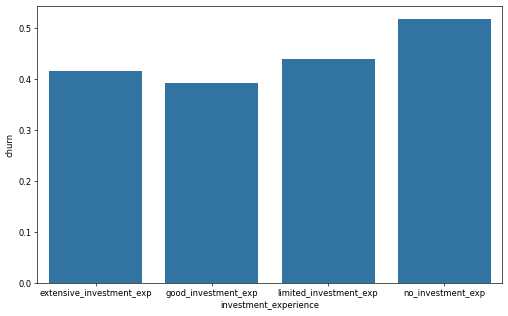

                                churn  user_id
liquidity_needs                               
not_important_liq_need       0.801932      207
somewhat_important_liq_need  0.770179      892
very_important_liq_need      0.349466     3368


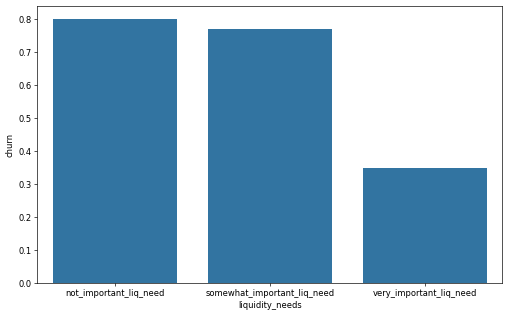

             churn  user_id
platform                   
Android   0.529508     1220
both      0.355499      391
iOS       0.435924     2856


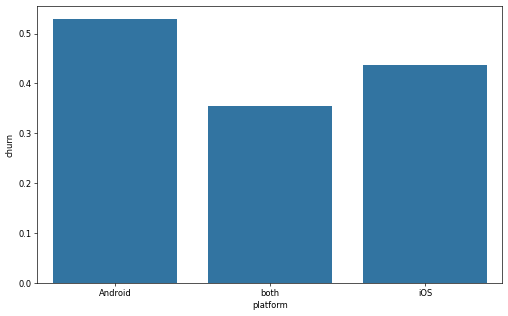

                                 churn  user_id
instrument_type_first_traded                   
0                             0.636364       11
adr                           0.366013      153
cef                           0.500000       18
etp                           0.347973      296
lp                            0.400000        5
mlp                           0.489362       47
reit                          0.488372       43
rlt                           0.571429        7
stock                         0.462552     3872
tracking                      1.000000        1
wrt                           0.928571       14


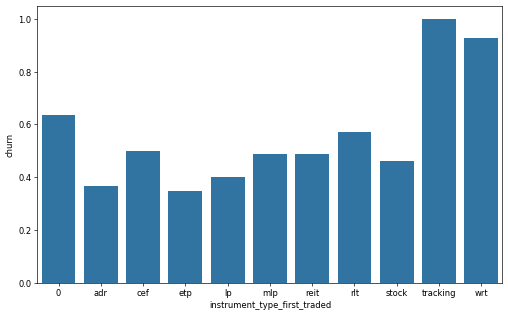

                       churn  user_id
time_horizon                         
long_time_horizon   0.436228     1474
med_time_horizon    0.451613      713
short_time_horizon  0.467105     2280


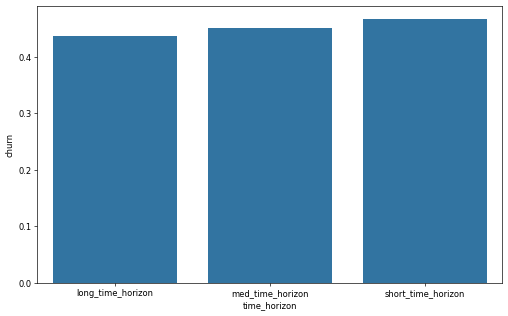

In [ ]:
for i in cat_features:
  x = train_df.groupby(i).agg({'churn':'mean','user_id':'count'})
  print(x)
  plt.figure(figsize=(10,6),dpi=60)
  sns.barplot(x=x.index, y=x.churn)
  plt.show()

**We can clearly see levels in risk_tolerance, investment_experience, liquidity_needs, platform have varying churn levels. Since these levels have clear discriminating power I believe these are good features for model. (instrument_type_first_traded- will explore later)**

In [ ]:
feature_map = {'risk_tolerance' : {'high_risk_tolerance':1, 'med_risk_tolerance':2, 'low_risk_tolerance':3},
              'investment_experience': {'extensive_investment_exp':1, 'good_investment_exp':2, 'limited_investment_exp':3, 'no_investment_exp':4},
              "liquidity_needs": {"not_important_liq_need":1, "somewhat_important_liq_need":2, "very_important_liq_need":3},
              'platform': {'Android':1, 'iOS':2, 'both':3},
              'time_horizon': {'long_time_horizon':1, 'med_time_horizon':2, 'short_time_horizon':3},
              'instrument_type_first_traded': {'etp': 1,'adr': 2,'stock': 3,'reit': 4,'cef': 5,'rlt': 6,'lp': 7,'mlp': 8,'0': 9,'wrt': 10, 'tracking': 11}
}

In [ ]:
for i in cat_features:
  train_df[i] = train_df[i].map(feature_map[i])
  test_df[i] = test_df[i].map(feature_map[i])

train_df['liquidity_needs'].sample(5)

,liquidity_needs
5016,3
1088,2
5524,3
3753,3
2489,3


In [ ]:
# Display a sample of the original 'platform' column (before mapping in the previous cell)
# Reload the merged_df to get the original categorical values for demonstration
temp_merged_df = feature_df.merge(user_churn_data,on='user_id',how='left')
temp_train_df, temp_test_df = train_test_split(temp_merged_df, test_size= 0.2, random_state = 2021)

print("Original 'platform' values (sample):")
display(temp_train_df['platform'].sample(2))

# Display a sample of the 'platform' column after mapping
print("\nMapped 'platform' values (sample):")
display(train_df['platform'].sample(3))

Original 'platform' values (sample):


,platform
1026,both
3207,iOS



Mapped 'platform' values (sample):


,platform
902,2
1185,2
1176,1


In [ ]:
# Check unique values and missing values in categorical features before mapping
print("Checking unique values and missing values in categorical features:")
for col in cat_features:
    print(f"\nFeature: {col}")
    print("Unique values:", train_df[col].unique())
    print("Missing values:", train_df[col].isnull().sum())

Checking unique values and missing values in categorical features:

Feature: risk_tolerance
Unique values: [1 2 3]
Missing values: 0

Feature: investment_experience
Unique values: [2 3 4 1]
Missing values: 0

Feature: liquidity_needs
Unique values: [3 2 1]
Missing values: 0

Feature: platform
Unique values: [1 2 3]
Missing values: 0

Feature: instrument_type_first_traded
Unique values: [ 3  1  2  4  5  8 10  6  7  9 11]
Missing values: 0

Feature: time_horizon
Unique values: [3 1 2]
Missing values: 0


Further check the importance of categorical features by conducting Chi2 test

In [ ]:
from sklearn import feature_selection
chi2_model = feature_selection.SelectKBest(feature_selection.chi2, k=2)
chi2_model.fit(train_df[cat_features], train_df['churn'])
chi2_values = pd.DataFrame(list(zip(train_df[cat_features].columns, chi2_model.scores_, chi2_model.pvalues_)), columns=['Feature', 'chi2-score', 'p-value'])
chi2_values

,Feature,chi2-score,p-value
0,risk_tolerance,12.104524,5.029963e-04
1,investment_experience,6.983846,8.224866e-03
2,liquidity_needs,60.376302,7.835059e-15
3,platform,8.444825,3.660837e-03
4,instrument_type_first_traded,7.075317,7.815299e-03
5,time_horizon,1.285637,2.568536e-01


Start with implementing Logistic Regression Model


In [ ]:
model_df_lr = model_df.copy()

Preparing data for Logistic Regression as it needs data to be treated

In [ ]:
model_df_lr = pd.get_dummies(model_df_lr, columns=cat_features) #onehotencoding
model_df_lr.head()

,time_spent,first_deposit_amount,user_id,churn,risk_tolerance_high_risk_tolerance,risk_tolerance_low_risk_tolerance,risk_tolerance_med_risk_tolerance,investment_experience_extensive_investment_exp,investment_experience_good_investment_exp,investment_experience_limited_investment_exp,...,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon
0,33.129417,40.0,895044c23edc821881e87da749c01034,1,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
1,16.573517,200.0,458b1d95441ced242949deefe8e4b638,0,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,10.008367,25.0,c7936f653d293479e034865db9bb932f,0,False,False,True,False,False,True,...,False,False,False,False,True,False,False,True,False,False
3,1.031633,100.0,b255d4bd6c9ba194d3a350b3e76c6393,1,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
4,8.187250,20.0,4a168225e89375b8de605cbc0977ae91,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False


MinMax scaling for continuous features

In [ ]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
for i in cont_features:
  x = model_df_lr[i].values.reshape(-1,1)
  scaler = MinMaxScaler(feature_range = (0,1))
  scaler.fit(x)
  model_df_lr[i] = scaler.transform(x)

In [ ]:
model_df_lr.describe()

,time_spent,first_deposit_amount,churn
count,5584.000000,5584.000000,5584.000000
mean,0.280824,0.279141,0.454334
std,0.308653,0.339083,0.497955
min,0.000000,0.000000,0.000000
25%,0.035484,0.042553,0.000000
50%,0.167833,0.085106,0.000000
75%,0.421291,0.425532,1.000000
max,1.000000,1.000000,1.000000


Defining features for Logistic Model

In [ ]:
lr_cols_for_model = list(model_df_lr.columns)
lr_cols_for_model.remove('user_id')
lr_cols_for_model.remove('churn')

**Split data into Train and Test**

In [ ]:
train_lr,test_lr = train_test_split(model_df_lr,test_size=0.2,random_state=2021)

**Fit Data and predit for test data using fitted Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_lr[lr_cols_for_model],train_lr['churn'],)
lr_test_probs=lr.predict_proba(test_lr[lr_cols_for_model])
print(f"Test AUC ROC of Logistic Regression Model is {roc_auc_score(test_lr['churn'],lr_test_probs[:,1])}")

Test AUC ROC of Logistic Regression Model is 0.7967116112135029


**Let's Look into coef of LR**

In [ ]:
dict(zip(lr_cols_for_model,lr.coef_[0]))

{'time_spent': np.float64(1.7026029854898397),
 'first_deposit_amount': np.float64(-0.8990870200817034),
 'risk_tolerance_high_risk_tolerance': np.float64(-0.15761287906798324),
 'risk_tolerance_low_risk_tolerance': np.float64(0.25983498751523376),
 'risk_tolerance_med_risk_tolerance': np.float64(0.20514032920955014),
 'investment_experience_extensive_investment_exp': np.float64(0.15306266568360274),
 'investment_experience_good_investment_exp': np.float64(-0.05728949922874517),
 'investment_experience_limited_investment_exp': np.float64(0.031105019176266107),
 'investment_experience_no_investment_exp': np.float64(0.1804842520256671),
 'liquidity_needs_not_important_liq_need': np.float64(0.9367574618078611),
 'liquidity_needs_somewhat_important_liq_need': np.float64(0.7685203352172425),
 'liquidity_needs_very_important_liq_need': np.float64(-1.3979153593683127),
 'platform_Android': np.float64(0.7112402337144133),
 'platform_both': np.float64(-0.20009868977658932),
 'platform_iOS': np.

**We can observe the coefficients are inline with log odds expected after looking at data visualization**

**Test AUC ROC of Logistic regression on test dataset is ~0.79. Can we do better? Yes.**

**Let's build LightGBM Model**

**Define LightGBM parameters**

In [ ]:
params = {
 'objective':'binary',
'boosting_type':'gbdt',
 'metric':'auc',
# 'n_jobs':-1,
 'learning_rate':0.001,
 'num_leaves': 16,
 'max_depth':3,
 'colsample_bytree': 0.6,
 'subsample_freq':1,
 'subsample':0.5,
 'n_estimators':4000,
 'min_data_in_leaf': 20,
 'lambda_l2':2,
 'verbose':-1,
 'seed': 2021,
 'early_stopping_rounds':200,
 }

**RunLGB Function to run LightGBM**

In [ ]:
def RunLGB(x_build,x_val,y_build,y_val,params=params, dep=4):

 num_rounds = 4000
 plst = list(params.items())
 lgbuild = lgb.Dataset(x_build, label=y_build)
 lgval = lgb.Dataset(x_val, label=y_val)
 model = lgb.train(params, lgbuild, num_rounds,
                   valid_sets=[lgbuild,lgval],
                   callbacks=[lgb.log_evaluation, lgb.early_stopping(200)])
 pred_val = model.predict(x_val, num_iteration=model.best_iteration)
 return(model,pred_val)


Further Splitting Train data into Build and Validation to implement early stopping and paramenter tuning

In [ ]:
x_build, x_val, y_build, y_val, = train_test_split(train_df[cols_for_model].fillna(-1), train_df['churn'], test_size=0.20, random_state=2021)
model,pred_v = RunLGB(x_build[cols_for_model],x_val[cols_for_model].fillna(-1),y_build,y_val)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[202]	training's auc: 0.810383	valid_1's auc: 0.792876


In [ ]:
best_iteration = model.best_iteration #202
best_iteration

202

**Let's look at Feature importance as per Information Gain**

<Axes: ylabel='feature'>

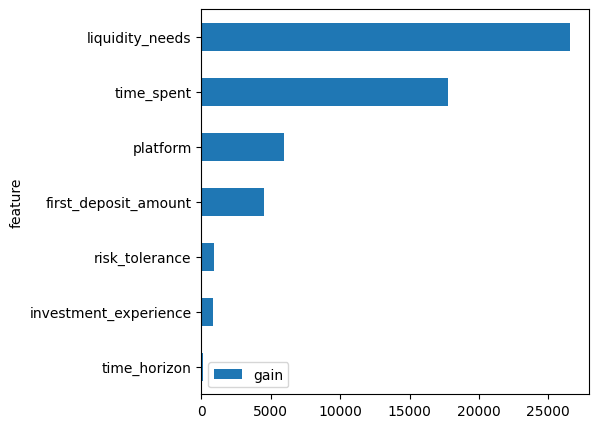

In [ ]:
(pd.DataFrame({"feature": model.feature_name(),
 "gain": model.feature_importance(importance_type="gain")}).sort_values("gain", ascending=True).set_index("feature").plot(kind="barh",
 figsize=(5,5)))

**Build Final Model on entire Train data to predict on Test data**

In [ ]:
params_final = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'learning_rate':0.001,
                'num_leaves': 16,
                'max_depth':3,
                'colsample_bytree': 0.6,
                'subsample_freq':1,
                'subsample':0.5,
                'n_estimators': best_iteration, #we're updating this from 4000
                'min_data_in_leaf': 20,
                'lambda_l2':2,
                'verbose':-1,
                'seed': 2021,
 }

In [ ]:
lgtrain = lgb.Dataset(train_df[cols_for_model], label=train_df['churn'])
model = lgb.train(params_final,lgtrain, callbacks=[lgb.log_evaluation(period=100)]) # Removed early_stopping callback
pred_test = model.predict(test_df[cols_for_model], num_iteration=best_iteration)

In [ ]:
test_preds_df = pd.DataFrame({"user_id": test_df["user_id"], "churn": test_df['churn'], "score":pred_test })

In [ ]:
print(f"AUC ROC of LightGBM model is {roc_auc_score(test_preds_df['churn'],test_preds_df['score'])}")

AUC ROC of LightGBM model is 0.8149949881980146


**Test AUC ROC of Model is ~0.8**

**Visualizing AUC ROC**

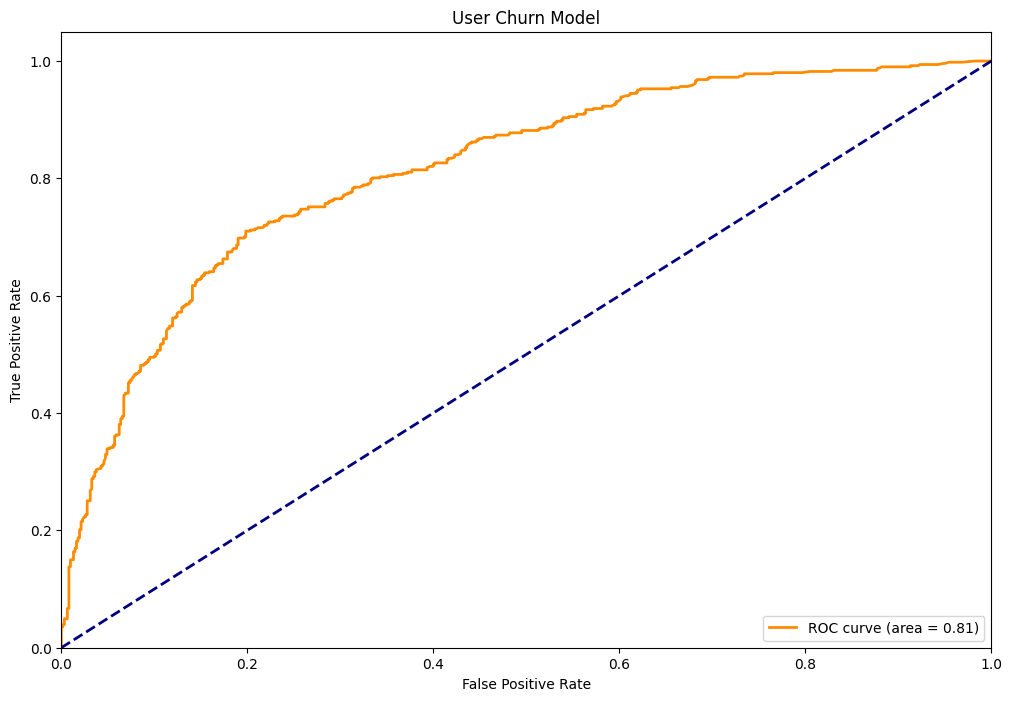

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_preds_df["churn"], test_preds_df["score"])
auc(fpr, tpr)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
 lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('User Churn Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
precision_lst = []
recall_lst = []
f1_lst = []
threshold = []
for i in np.linspace(0,1,100):
 yhat = np.where(test_preds_df['score'].values>i,1,0)
 threshold.append(i)
 precision_lst.append(precision_score(test_preds_df['churn'],yhat))
 recall_lst.append(recall_score(test_preds_df['churn'],yhat))
 f1_lst.append(f1_score(test_preds_df['churn'],yhat))
metrics_df = pd.DataFrame({"treshold":threshold,"precision":precision_lst,"recall":recall_lst,"F1_score":f1_lst})

In [ ]:
metrics_df.sort_values("F1_score",ascending=False).head(5)

,treshold,precision,recall,F1_score
45,0.454545,0.713193,0.735700,0.724272
44,0.444444,0.628186,0.826430,0.713799
43,0.434343,0.576441,0.907298,0.704981
46,0.464646,0.780788,0.625247,0.694414
42,0.424242,0.536532,0.970414,0.691011


**Let's look at confusion Matrix for best F1 Score Treshold**

In [ ]:
confusion_matrix(test_preds_df['churn'],np.where(test_preds_df['score'].values>0.454545,1,0))

array([[460, 150],
       [134, 373]])

**Let's build XGBoost Model**

In [ ]:
import xgboost as xgb

# Define XGBoost parameters
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.01,
    'max_depth': 3,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'seed': 2021
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(train_df[cols_for_model].fillna(-1), label=train_df['churn'])
dtest = xgb.DMatrix(test_df[cols_for_model].fillna(-1), label=test_df['churn'])

# Train the XGBoost model
num_rounds = 1000
model_xgb = xgb.train(params_xgb, dtrain, num_rounds)

# Predict probabilities on the test set
pred_test_xgb = model_xgb.predict(dtest)

# Evaluate the model
auc_roc_xgb = roc_auc_score(test_df['churn'], pred_test_xgb)
print(f"AUC ROC of XGBoost model is {auc_roc_xgb}")

AUC ROC of XGBoost model is 0.8165858311507744


**Visualizing AUC ROC for XGBoost**

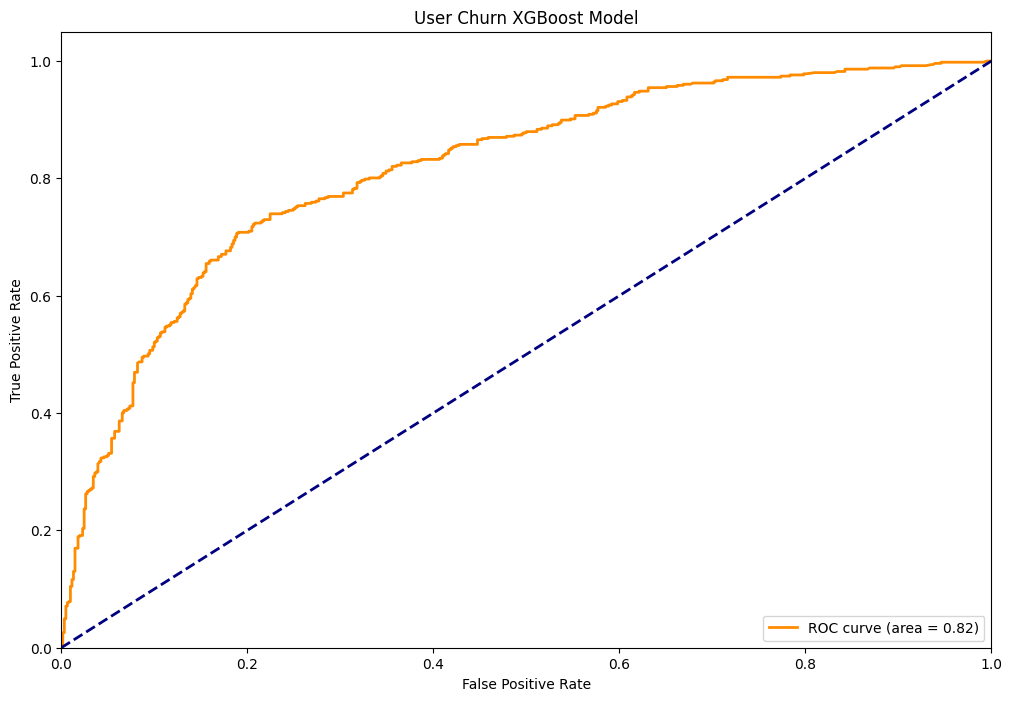

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_xgb, tpr_xgb, _ = roc_curve(test_df["churn"], pred_test_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(12, 8))
lw = 2
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
 lw=lw, label='ROC curve (area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('User Churn XGBoost Model')
plt.legend(loc="lower right")
plt.show()

**Let's look at confusion Matrix for XGBoost**

In [ ]:
# Find the optimal threshold for F1-score (or another desired metric) for XGBoost
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
threshold_xgb = []

for i in np.linspace(0, 1, 100):
    yhat_xgb = np.where(pred_test_xgb > i, 1, 0)
    threshold_xgb.append(i)
    precision_lst_xgb.append(precision_score(test_df['churn'], yhat_xgb))
    recall_lst_xgb.append(recall_score(test_df['churn'], yhat_xgb))
    f1_lst_xgb.append(f1_score(test_df['churn'], yhat_xgb))

metrics_df_xgb = pd.DataFrame({"treshold": threshold_xgb, "precision": precision_lst_xgb, "recall": recall_lst_xgb, "F1_score": f1_lst_xgb})

best_f1_threshold_xgb = metrics_df_xgb.sort_values("F1_score", ascending=False).iloc[0]['treshold']
print(f"Best F1-score threshold for XGBoost: {best_f1_threshold_xgb}")

# Display the confusion matrix for the best F1-score threshold
conf_matrix_xgb = confusion_matrix(test_df['churn'], np.where(pred_test_xgb > best_f1_threshold_xgb, 1, 0))
print("\nConfusion Matrix for XGBoost:")
display(conf_matrix_xgb)

Best F1-score threshold for XGBoost: 0.4646464646464647

Confusion Matrix for XGBoost:


array([[470, 140],
       [132, 375]])

### **Conclusion**
We were able to build a classification model with AUC ROC of ~0.82 (using LightGBM, XGBOOST).
We can further improve predictions by using more features like transaction features, app activity features, and their equity growth features.
We can further finetune model for metric we need to optimize. In this case I believe the most important metric would be Recall because we should proactively improve engagement of potential churn users.
Further this prediction score can be utilized for retention/engagement strategies